# EDGAR v5 N2O Emissions of Africa for 2015

A quick analysis of the reported N2O emissions for Africa.  

EDGAR data: [source](https://edgar.jrc.ec.europa.eu/overview.php?v=50_GHG)

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import math
import sys
import xarray as xr
import matplotlib.pyplot as plt

module_path = Path.cwd().resolve()
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.geo import create_area_grid
# import patched path (contains ls())
from utils.misc import Path

In [3]:
def preprocess_edgar_nc(da, convert_n2o_units=True):
    if convert_n2o_units:
        if da.units == 'kg m-2 s-1':
            da = da * 3600 * 24 * 365 * 10000
            da.attrs['units'] = 'kg ha-1 yr-1'
        else:
            print('unexpected unit - no conversion')

    # also shift dataset from 0...360 longitude to -180...180
    da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180)).sortby('lon')
    da['lon'].attrs['long_name'] = 'longitude [degrees_east]'
    return da

In [4]:
def simple_plot(da, title=None, robust=True, cmap='viridis', units='kg N ha-1 yr-1'):
    fig, ax = plt.subplots(1, 1, figsize=(5,4))
    if title:
        fig.suptitle(title, x=.45, fontsize=16)
    da.plot(ax=ax, robust=robust, cmap=cmap, cbar_kwargs={'label': units})

In [5]:
def report_total(da, title):
    total = float((da*area).sum()) / 1_000_000
    print(f"{title}: {total:.1f} Gg N2O yr-1")

In [6]:
data_path = Path('data')
data_path.ls(recursive=True)

[PosixPath('data/tmworld'),
 PosixPath('data/tmworld/.ipynb_checkpoints'),
 PosixPath('data/tmworld/.ipynb_checkpoints/Untitled-checkpoint.ipynb'),
 PosixPath('data/tmworld/.ipynb_checkpoints/Untitled1-checkpoint.ipynb'),
 PosixPath('data/tmworld/tmworld-ms.dbf'),
 PosixPath('data/tmworld/tmworld-ms.prj'),
 PosixPath('data/tmworld/tmworld-ms.shp'),
 PosixPath('data/tmworld/tmworld-ms.shx'),
 PosixPath('data/tmworld/tmworld_01deg.nc'),
 PosixPath('data/tmworld/tmworld_HR.nc'),
 PosixPath('data/tmworld/tmworld_LR.nc'),
 PosixPath('data/tmworld/tmworld_MR.nc'),
 PosixPath('data/tmworld/tmworld_countries_lut.txt'),
 PosixPath('data/tmworld/tmworld_full_lut.txt'),
 PosixPath('data/tmworld/tmworld_iso2_lut.txt'),
 PosixPath('data/tmworld/tmworld_regions_lut.txt'),
 PosixPath('data/tmworld/tmworld_subregions_lut.txt'),
 PosixPath('data/tmworld/tmworldtable.xls'),
 PosixPath('data/v50_N2O_2015'),
 PosixPath('data/v50_N2O_2015/_readme.html'),
 PosixPath('data/v50_N2O_2015/v50_N2O_2015.0.1x0.1.n

In [7]:
n2o = xr.open_dataset(data_path / 'v50_N2O_2015' / 'v50_N2O_2015.0.1x0.1.nc')['emi_n2o']
n2o = preprocess_edgar_nc(n2o)

In [8]:
# create an area grid for calculation of totals (use n2o data grid as ref)
area = create_area_grid(n2o)

In [9]:
# africa/ sub-sahara masks
# codes can be obtained from the lut files in data/tmworld
admin = xr.open_dataset(data_path / 'tmworld' / 'tmworld_01deg.nc').sel(lat=slice(-50,40), lon=slice(-30, 60))

africa = admin.REGION.where(admin.REGION == 2).notnull()
africa = africa.where(africa == 1)

subafrica = (admin.SUBREGION.where(admin.REGION == 2)
                            .where(admin.SUBREGION != 15)
                            .notnull())
subafrica = subafrica.where(subafrica == 1)

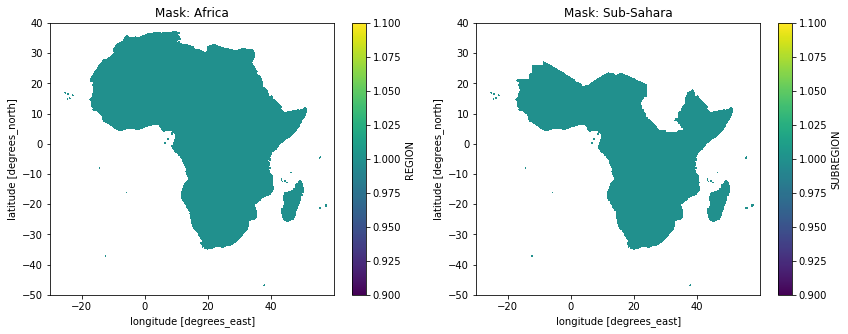

In [10]:
fig, ax = plt.subplots(1, 2 , figsize=(14,5))
africa.plot(ax=ax[0])
subafrica.plot(ax=ax[1])
ax[0].set_title("Mask: Africa")
ax[1].set_title("Mask: Sub-Sahara");

## Total N2O emissions

### Africa

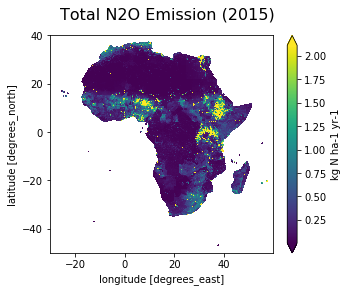

In [11]:
simple_plot(n2o*africa, title="Total N2O Emission (2015)")

In [12]:
report_total((n2o*africa), "Total annual N2O emission")

Total annual N2O emission: 975.1 Gg N2O yr-1


### Sub-Sahara

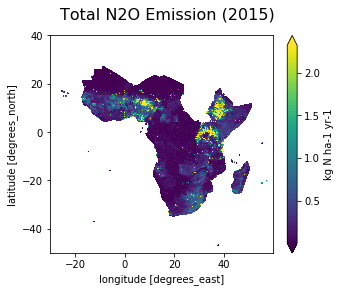

In [13]:
simple_plot(n2o*subafrica, title="Total N2O Emission (2015)")

In [14]:
report_total((n2o*subafrica), "Total annual N2O emission")

Total annual N2O emission: 770.7 Gg N2O yr-1


## Manure management

### Africa

In [15]:
manure = xr.open_dataset(data_path / 'v50_N2O_2015_MNM' / 'v50_N2O_2015_MNM.0.1x0.1.nc')['emi_n2o']
manure = preprocess_edgar_nc(manure)

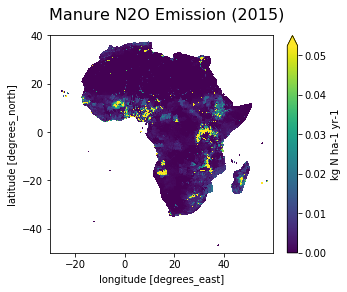

In [16]:
simple_plot(manure*africa, title="Manure N2O Emission (2015)")

In [17]:
report_total((manure*africa), "Annual N2O emission from manure management")

Annual N2O emission from manure management: 17.0 Gg N2O yr-1


### Sub-Sahara

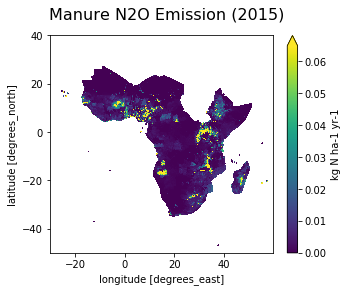

In [18]:
simple_plot(manure*subafrica, title="Manure N2O Emission (2015)")

In [19]:
report_total((manure*subafrica), "Annual N2O emission from manure management")

Annual N2O emission from manure management: 15.3 Gg N2O yr-1


## Agricultural soils

### Africa

In [20]:
soil = xr.open_dataset(data_path / 'v50_N2O_2015_AGS' / 'v50_N2O_2015_AGS.0.1x0.1.nc')['emi_n2o']
soil = preprocess_edgar_nc(soil)

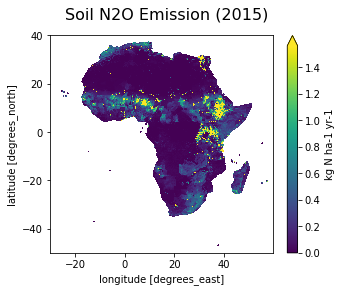

In [21]:
simple_plot(soil*africa, title="Soil N2O Emission (2015)")

In [22]:
report_total((soil*africa), "Annual N2O emission from soil")

Annual N2O emission from soil: 683.1 Gg N2O yr-1


### Sub-Sahara

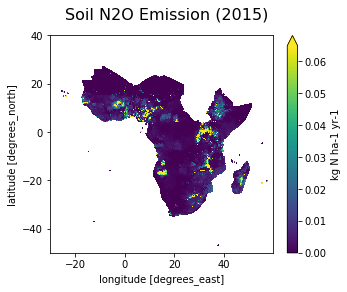

In [23]:
simple_plot(manure*subafrica, title="Soil N2O Emission (2015)")

In [24]:
report_total((soil*subafrica), "Annual N2O emission from soil")

Annual N2O emission from soil: 543.9 Gg N2O yr-1


## Indirect N2O from agriculture

### Africa

In [25]:
indirect = xr.open_dataset(data_path / 'v50_N2O_2015_N2O' / 'v50_N2O_2015_N2O.0.1x0.1.nc')['emi_n2o']
indirect = preprocess_edgar_nc(indirect)

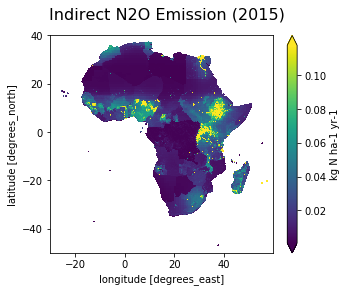

In [26]:
simple_plot(indirect*africa, title="Indirect N2O Emission (2015)")

In [27]:
report_total((indirect*africa), "Indirect N2O emission from agriculture")

Indirect N2O emission from agriculture: 69.6 Gg N2O yr-1


### Sub-Sahara

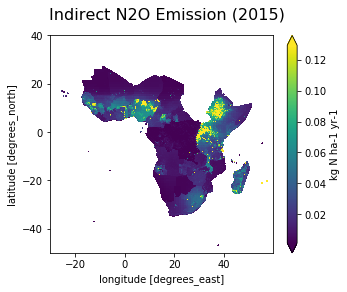

In [28]:
simple_plot(indirect*subafrica, title="Indirect N2O Emission (2015)")

In [29]:
report_total((indirect*subafrica), "Indirect N2O emission from agriculture")

Indirect N2O emission from agriculture: 55.7 Gg N2O yr-1


## Total N2O from Agriculture

### Africa

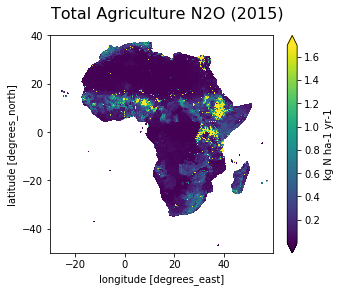

In [30]:
simple_plot((manure+soil+indirect)*africa, title="Total Agriculture N2O (2015)")

In [31]:
report_total(((manure+soil+indirect)*africa), "Total N2O emission from agriculture")

Total N2O emission from agriculture: 769.6 Gg N2O yr-1


### Sub-Sahara

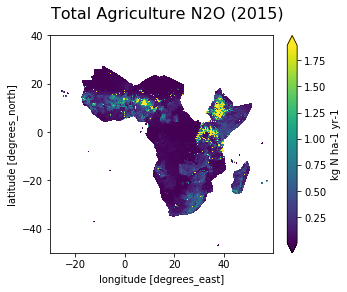

In [32]:
simple_plot((manure+soil+indirect)*subafrica, title="Total Agriculture N2O (2015)")

In [33]:
report_total(((manure+soil+indirect)*subafrica), "Total N2O emission from agriculture")

Total N2O emission from agriculture: 614.9 Gg N2O yr-1


## Ratio of total agriculture N2O to total N2O

### Africa

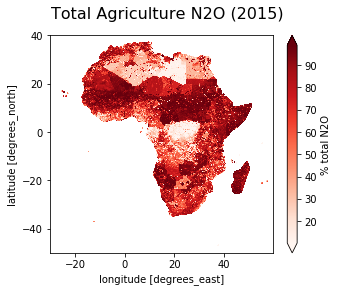

In [34]:
simple_plot(((manure+soil+indirect)/n2o)*africa * 100, 
            title="Total Agriculture N2O (2015)",
            units='% total N2O',
            cmap='Reds')

### Sub-Sahara

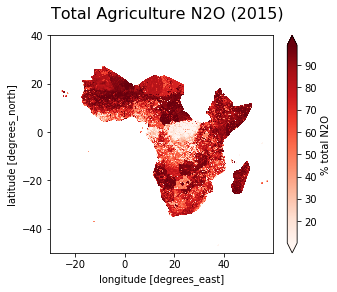

In [35]:
simple_plot(((manure+soil+indirect)/n2o)*subafrica * 100, 
            title="Total Agriculture N2O (2015)", 
            units='% total N2O',
            cmap='Reds')